# 10. PyTorch Model Deployment Exercises

Welcome to the 10. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 10. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [10. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 33.78 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a986d5a8530>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

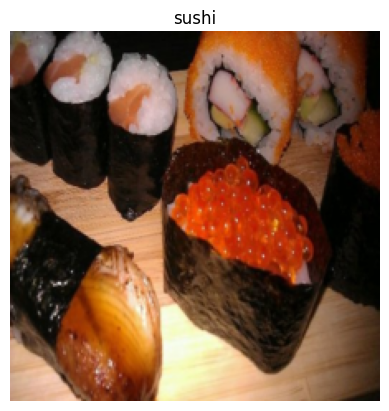

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

## 1.1 Get the EffnetB2 & ViT

In [ ]:
def create_effnetb2(class_names):
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(effnetb2_weights)

  for params in effnetb2.features.parameters():
    params.requires_grad = False

  effnetb2.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=len(class_names))
  )

  return effnetb2, effnetb2_transforms

def output_summary(model=torch.nn.Module):
  print(summary(
      model=model,
      input_size=(1,3,224,224),
      col_names=['input_size', 'output_size', 'trainable', 'num_params'],
      row_settings=['var_names'],
      col_width=20,
  ))

effnetb2, effnetb2_transforms = create_effnetb2(class_names)
output_summary(effnetb2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:01<00:00, 36.2MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               Partial              --
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      False                --
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    False                --
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    False                (864)
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    False                (64)
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]  

In [ ]:
def create_vit(class_names):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  vit_transforms = vit_weights.transforms()
  vit = torchvision.models.vit_b_16(vit_weights)

  for params in vit.parameters():
    params.requires_grad = False

  vit.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=len(class_names), bias=True)
  )

  return vit, vit_transforms

vit, vit_transforms = create_vit(class_names)
output_summary(vit)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:07<00:00, 43.7MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               Partial              768
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     False                (590,592)
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        False                151,296
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        False                --
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        False                (7,087,872)
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1

In [ ]:
from going_modular.going_modular.data_setup import create_dataloaders

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(
    train_dir,
    test_dir,
    batch_size=BATCH_SIZE,
    transform=effnetb2_transforms)

train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir,
    test_dir,
    batch_size=BATCH_SIZE,
    transform=vit_transforms)

## 1.2 Train both models

In [ ]:
from going_modular.going_modular.engine import train

# Setup loss and optimizer
loss_fn_effnetb2 = nn.CrossEntropyLoss()
loss_fn_vit = nn.CrossEntropyLoss()
optimizer_effnetb2 = torch.optim.Adam(effnetb2.parameters(),0.001)
optimizer_vit = torch.optim.Adam(vit.parameters(),0.001)

effnetb2_results = train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=5,
    optimizer=optimizer_effnetb2,
    loss_fn=loss_fn_effnetb2,
    device=device,
)


vit_results = train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    epochs=5,
    optimizer=optimizer_vit,
    loss_fn=loss_fn_vit,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9788 | train_acc: 0.5500 | test_loss: 0.7273 | test_acc: 0.9074
Epoch: 2 | train_loss: 0.7228 | train_acc: 0.8208 | test_loss: 0.5883 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.5860 | train_acc: 0.8104 | test_loss: 0.4893 | test_acc: 0.9472
Epoch: 4 | train_loss: 0.5691 | train_acc: 0.8063 | test_loss: 0.4486 | test_acc: 0.9165
Epoch: 5 | train_loss: 0.5011 | train_acc: 0.8250 | test_loss: 0.3812 | test_acc: 0.9597


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5726 | train_acc: 0.8313 | test_loss: 0.2096 | test_acc: 0.9875
Epoch: 2 | train_loss: 0.1937 | train_acc: 0.9521 | test_loss: 0.1129 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1388 | train_acc: 0.9646 | test_loss: 0.0859 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1215 | train_acc: 0.9688 | test_loss: 0.0743 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.0968 | train_acc: 0.9729 | test_loss: 0.0662 | test_acc: 0.9938


### 1.3 Calculate inference time using test_step for dataloaders and then divide by number

In [ ]:
from going_modular.going_modular.engine import test_step
from timeit import default_timer as timer

start_time = timer()
effnetb2_test_loss, effnetb2_test_acc = test_step(
    effnetb2.to('cpu'),
    test_dataloader_effnetb2,
    loss_fn_effnetb2,
    device='cpu'
)
end_time = timer()
effnet_pred_time = round(end_time-start_time, 4)

start_time = timer()
vit_test_loss, vit_test_acc = test_step(
    vit.to('cpu'),
    test_dataloader_vit,
    loss_fn_vit,
    device='cpu'
)
end_time = timer()
vit_pred_time = round(end_time-start_time, 4)

# Per image time
effnet_pred_time = (effnet_pred_time / len(test_dataloader_effnetb2)) / BATCH_SIZE
vit_pred_time = (vit_pred_time / len(test_dataloader_vit)) / BATCH_SIZE


print(f'EffNetB2 pred time CPU: {effnet_pred_time*1000:.2f} ms')
print(f'ViT pred time CPU: {vit_pred_time*1000:.2f} ms')

EffNetB2 pred time CPU: 177.90 ms
ViT pred time CPU: 465.04 ms


In [ ]:
from going_modular.going_modular.engine import test_step
from timeit import default_timer as timer

start_time = timer()
effnetb2_test_loss, effnetb2_test_acc = test_step(
    effnetb2.to(device),
    test_dataloader_effnetb2,
    loss_fn_effnetb2,
    device=device
)
end_time = timer()
effnet_pred_time = round(end_time-start_time, 4)

start_time = timer()
vit_test_loss, vit_test_acc = test_step(
    vit.to(device),
    test_dataloader_vit,
    loss_fn_vit,
    device=device
)
end_time = timer()
vit_pred_time = round(end_time-start_time, 4)

# Per image time
effnet_pred_time = (effnet_pred_time / len(test_dataloader_effnetb2)) / BATCH_SIZE
vit_pred_time = (vit_pred_time / len(test_dataloader_vit)) / BATCH_SIZE


print(f'EffNetB2 pred time GPU: {effnet_pred_time*1000:.2f} ms')
print(f'ViT pred time GPU: {vit_pred_time*1000:.2f} ms')

EffNetB2 pred time GPU: 11.56 ms
ViT pred time GPU: 13.35 ms


In both the cases the ViT model takes significantly longer time to produce the outputs given the inherent presence of more parameters in them.

It is 2x slower on GPU and almost 3x slower on CPU

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

### 2.1 Re-create the ViT-Base with 101 classes

In [ ]:
food101_dummy_list = [0] * 101
vit, vit_transforms = create_vit(food101_dummy_list)
output_summary(vit)

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             Partial              768
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     False                (590,592)
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        False                151,296
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        False                --
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        False                (7,087,872)
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1

### 2.2 Create a train tarnsforms which also does an addition augmentation to training data

In [ ]:
vit_transforms_train = torchvision.transforms.Compose([
    transforms.TrivialAugmentWide(),
    vit_transforms,
])

### 2.3 Retrive the Food101 dataset from PyTorch

In [ ]:
from pathlib import Path
food101_path = Path('data/food101')
food101_train_dir = food101_path / 'train'
food101_test_dir = food101_path / 'test'

train_data_food101 = torchvision.datasets.Food101(root=food101_train_dir,
                                                  split='train',
                                                  transform=vit_transforms_train,
                                                  download=True)

test_data_food101 = torchvision.datasets.Food101(root=food101_test_dir,
                                                 split='test',
                                                 transform=vit_transforms,
                                                 download=True)

100%|██████████| 5.00G/5.00G [04:07<00:00, 20.2MB/s]
100%|██████████| 5.00G/5.00G [09:51<00:00, 8.45MB/s]


### 2.4 Split the dataset for our usecase (20%)

In [ ]:
def split_data(dataset, split, seed):
  full_len = len(dataset)
  len_1 = int(full_len * split)
  len_2 = full_len - len_1
  data_split_1, data_split_2 = torch.utils.data.random_split(dataset,
                                                             lengths=[len_1,len_2],
                                                             generator=torch.manual_seed(seed))
  return data_split_1, data_split_2

train_data_food101_20_percent, _ = split_data(train_data_food101, 0.2, 42)
test_data_food101_20_percent, _ = split_data(test_data_food101, 0.2, 42)

### 2.5 Create Dataloaders for training

In [ ]:
# Create train and test dataloaders
train_dataloader_food101 = torch.utils.data.DataLoader(
    train_data_food101_20_percent,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_dataloader_food101 = torch.utils.data.DataLoader(
    test_data_food101_20_percent,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

# Get the names of classes
food101_classes = test_data_food101.classes
food101_classes[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 2.6 Train the new ViT-Base model on 20% of Food101

In [ ]:
from going_modular.going_modular.engine import train

# Setup loss and optimizer
loss_fn_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(vit.parameters(),0.001)

vit_results = train(
    model=vit,
    train_dataloader=train_dataloader_food101,
    test_dataloader=test_dataloader_food101,
    epochs=5,
    optimizer=optimizer_vit,
    loss_fn=loss_fn_vit,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4684 | train_acc: 0.4269 | test_loss: 1.4908 | test_acc: 0.6095
Epoch: 2 | train_loss: 1.6524 | train_acc: 0.5916 | test_loss: 1.2661 | test_acc: 0.6613
Epoch: 3 | train_loss: 1.4412 | train_acc: 0.6390 | test_loss: 1.1977 | test_acc: 0.6745
Epoch: 4 | train_loss: 1.3000 | train_acc: 0.6730 | test_loss: 1.1439 | test_acc: 0.6909
Epoch: 5 | train_loss: 1.2244 | train_acc: 0.6866 | test_loss: 1.1145 | test_acc: 0.6955


### 2.7 Plot loss curves

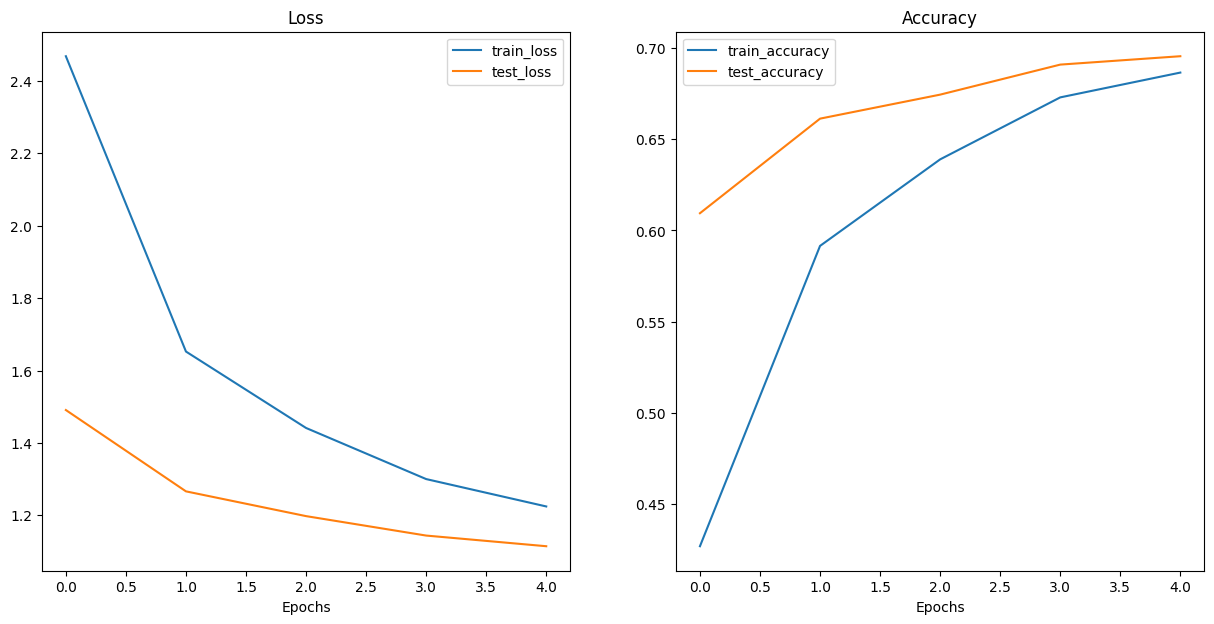

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

The test accuracy for the ViT-Base model is around 70% after training for only 5 epochs, it could be trained for 5 more epochs atleast until the train loss would meet the test loss.

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

### 3.1 Define function which predicts on all test data and returns most worng predictions

In [ ]:
def calc_wrong_preds(test_dataloader,
                     device,
                     model:torch.nn.Module,
                     class_names):

  # Dict for most wrong predictions
  wrong_preds = []

  # Set the model to eval mode
  model.eval()

  # Turn on inference
  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      # Set both to device
      X, y = X.to(device), y.to(device)
      # Make forward pass
      y_logits = model(X)
      # Get the prediction probabilities
      y_pred_probs = y_logits.softmax(dim=1)
      # Get the prediction label
      y_pred_label = y_pred_probs.argmax(dim=1)

      # Loop through the batch to find the wrong predictions
      for img, pred_label, pred_probs, gt in zip(X,y_pred_label,y_pred_probs,y):
        # Prediction metrics
        pred_metrics = {}
        if pred_label != gt: # Only add to array if it is a wrong prediction
          pred_metrics['class_name'] = class_names[pred_label]
          pred_metrics['pred_prob'] = pred_probs.max()
          pred_metrics['image'] = img
          pred_metrics['ground_truth'] = gt
          wrong_preds.append(pred_metrics)

  return wrong_preds

### 3.2 Call the function and check out the predictions

In [ ]:
wrong_preds = calc_wrong_preds(test_dataloader_food101,
                               device,
                               vit,
                               food101_classes)

### 3.3 Sort the predicition probabilities and analyze

In [ ]:
# Sort the predicitons
sorted_wrong_preds = sorted(wrong_preds, key=lambda d: d['pred_prob'], reverse=True)

most_wrong = sorted_wrong_preds[0]

## 3.4 Display the image

Text(0.5, 1.0, 'gyoza | dumplings | 0.99')

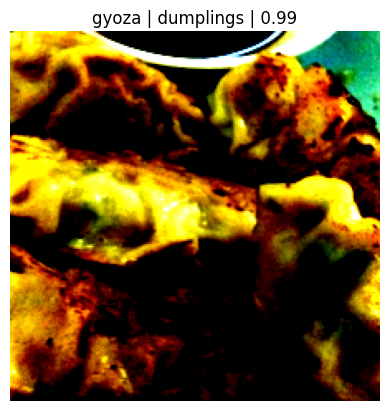

In [ ]:
plt.imshow(most_wrong['image'].permute(1,2,0).cpu())
plt.axis(False)
plt.title(f'{most_wrong['class_name']} | {food101_classes[most_wrong['ground_truth']]} | {most_wrong['pred_prob']:.2f}')

Most wrong was the dumpling which was predicted to be gyoza. This might be becase they both are made from rice dough and seem to have similar texture.

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

### 4.1 Make a new dataloader with all the images

In [ ]:
from torch.utils.data import DataLoader
test_dataloader_food101_full = DataLoader(
    dataset=test_data_food101,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)
test_dataloader_food101_full

### 4.2 Use the test_step function for test accuracy and test loss

In [ ]:
from going_modular.going_modular.engine import test_step

test_loss_food101, test_acc_food101 = test_step(
    model=vit,
    dataloader=test_dataloader_food101_full,
    loss_fn=loss_fn_vit,
    device=device,
)
test_loss_food101, test_acc_food101

(1.1088964523818297, 0.6989319620253165)

The test accuracy is 70%. It is higher than the paper accuracy by 14%

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

The best performing model on Food101 dataset is called [quanla/vit-base-patch16-224-in21k-finetuned-lora-food101](https://huggingface.co/quanla/vit-base-patch16-224-in21k-finetuned-lora-food101). It uses the same vit architecture from the ['An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale'](https://arxiv.org/abs/2010.11929) paper

In [ ]:
from transformers import ViTImageProcessor, ViTModel
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
output_summary(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type (var_name))                                           Input Shape          Output Shape         Trainable            Param #
ViTModel (ViTModel)                                               [1, 3, 224, 224]     [1, 768]             True                 --
├─ViTEmbeddings (embeddings)                                      [1, 3, 224, 224]     [1, 197, 768]        True                 152,064
│    └─ViTPatchEmbeddings (patch_embeddings)                      [1, 3, 224, 224]     [1, 196, 768]        True                 --
│    │    └─Conv2d (projection)                                   [1, 3, 224, 224]     [1, 768, 14, 14]     True                 590,592
│    └─Dropout (dropout)                                          [1, 197, 768]        [1, 197, 768]        --                   --
├─ViTEncoder (encoder)                                            [1, 197, 768]        [1, 197, 768]        True                 --
│    └─ModuleList (layer)                                    

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

1. Any image not in the dataset would wrongly try to predict an class which it is closest too.
- Solution: Add a minimal threshold which the model prediction has to cross to be considered a valid prediction, else we flag it as a invalid input
2. If the image uploaded is of lesser resoluiton than 224. If it is bigger than 224 it is easier to downsize, but not upsize
- Solution: mandate a minimum uplaod size of few KBs which a 224, 224 image would be
3. If a certain image has multiple food items, this may not work as the model is trained on a dataset with one item per image
- Solution: : Use a more robust model like YOLO or Faster RCNN to detect and classify multiple foods in the image

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

### 7.2 Get the VGG16 model with the pretrained weights and transforms


In [ ]:
def output_summary(model=torch.nn.Module):
  print(summary(
      model=model,
      input_size=(1,3,224,224),
      col_names=['input_size', 'output_size', 'trainable', 'num_params'],
      row_settings=['var_names'],
      col_width=20,
  ))

In [ ]:
def create_vgg():
  vgg_weights = torchvision.models.VGG16_Weights
  vgg_transforms = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
  vgg = torchvision.models.vgg16(vgg_weights)

  for params in vgg.parameters():
    params.requires_grad = False

  vgg.classifier[6] = nn.Linear(4096, 10)
  output_summary(vgg)

  return vgg, vgg_transforms
vgg, vgg_transforms = create_vgg()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape          Output Shape         Trainable            Param #
VGG (VGG)                                [1, 3, 224, 224]     [1, 10]              Partial              --
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       False                --
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    False                (1,792)
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    False                (36,928)
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   False                (73,856)
│    └─ReLU (6)

### 7.1 Get the FashionMNIST Dataset

In [ ]:
vgg_transforms = torchvision.transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    vgg_transforms,
])
vgg_transforms

Compose(
    Grayscale(num_output_channels=3)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [ ]:
!rm -r 'data/fmnist'

In [ ]:
from pathlib import Path
data_path_fmnist = Path('data/fmnist')
train_dir_fmnist = data_path_fmnist / 'train'
test_dir_fmnist = data_path_fmnist / 'test'

train_data_food101 = torchvision.datasets.FashionMNIST(root=train_dir_fmnist,
                                                  train=True,
                                                  download=True,
                                                  transform=vgg_transforms)

test_data_food101 = torchvision.datasets.FashionMNIST(root=test_dir_fmnist,
                                                 train=False,
                                                 download=True,
                                                 transform=vgg_transforms)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.82MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]


### 7.3 Create DataLoaders

In [ ]:
def split_data(dataset, split, seed):
  full_len = len(dataset)
  len_1 = int(full_len * split)
  len_2 = full_len - len_1
  data_split_1, data_split_2 = torch.utils.data.random_split(dataset,
                                                             lengths=[len_1,len_2],
                                                             generator=torch.manual_seed(seed))
  return data_split_1

train_data_fmnist = split_data(train_data_food101, 0.1, 42)
test_data_fmnist = split_data(test_data_food101, 0.1, 42)

len(train_data_fmnist), len(test_data_fmnist)

(6000, 1000)

In [ ]:
# Create train and test dataloaders
train_dataloader_fmnist = torch.utils.data.DataLoader(
    train_data_fmnist,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)

test_dataloader_fmnist = torch.utils.data.DataLoader(
    test_data_fmnist,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

# Get the names of classes
fmnist_classes = train_data_food101.classes
fmnist_classes[:5]

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']

### 7.4 Train the VGG16 Model using the VGG16


In [ ]:
from going_modular.going_modular.engine import train

# Setup loss and optimizer
loss_fn_vgg = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.Adam(vgg.parameters(),0.001)

vit_results = train(
    model=vgg,
    train_dataloader=train_dataloader_fmnist,
    test_dataloader=test_dataloader_fmnist,
    epochs=5,
    optimizer=optimizer_vgg,
    loss_fn=loss_fn_vgg,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7922 | train_acc: 0.7206 | test_loss: 0.5193 | test_acc: 0.8145
Epoch: 2 | train_loss: 0.5760 | train_acc: 0.7862 | test_loss: 0.4862 | test_acc: 0.8213


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782203f26520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x782203f26520>
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    AssertionErrorif 

Epoch: 3 | train_loss: 0.5409 | train_acc: 0.8044 | test_loss: 0.4656 | test_acc: 0.8271
Epoch: 4 | train_loss: 0.5135 | train_acc: 0.8097 | test_loss: 0.4565 | test_acc: 0.8242


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782203f26520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x782203f26520>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():
^ ^ ^  ^

Epoch: 5 | train_loss: 0.5019 | train_acc: 0.8177 | test_loss: 0.4687 | test_acc: 0.8389


### 7.5 Plot Loss Curves

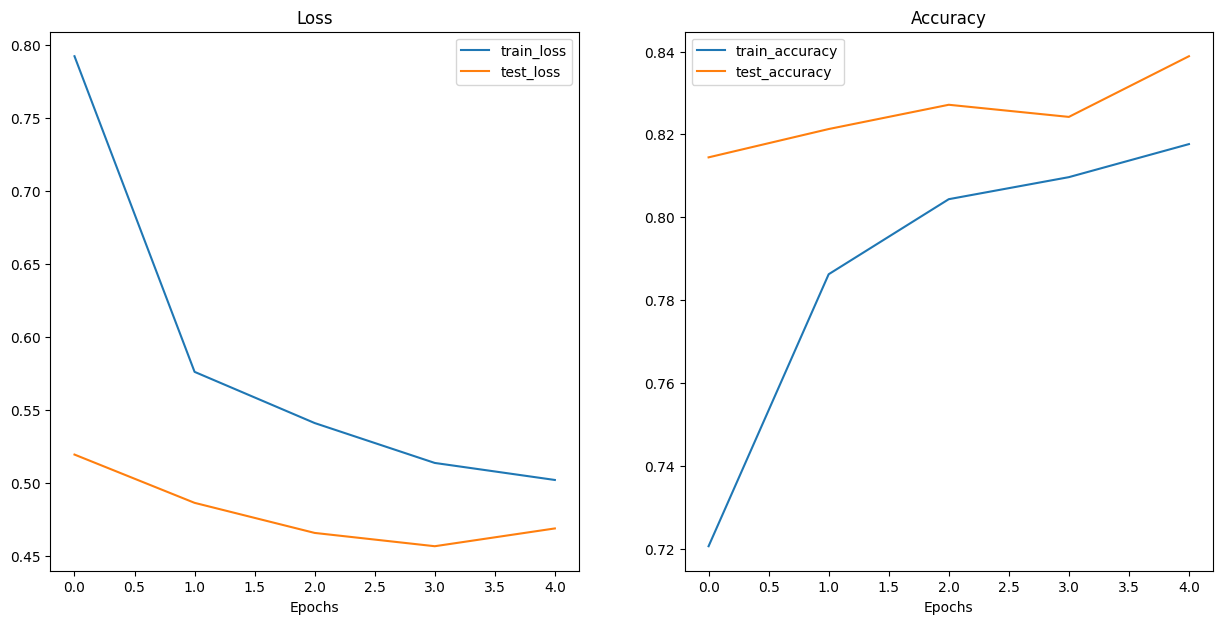

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 7.6 Save Model

In [ ]:
from going_modular.going_modular.utils import save_model

# Target model path
target_dir = 'models'
# Model name
model_name = 'vgg_fmnist_20_percent_5epochs.pth'

save_model(
    model=vgg,
    model_name=model_name,
    target_dir=target_dir
)

[INFO] Saving model to: models/vgg_fmnist_20_percent_5epochs.pth


### 7.7 Make a predict function

In [ ]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(image):
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start timer
  start_time = timer()

  # Transfrom the image using VGG architecture
  image = vgg_transforms(image).unsqueeze(0).to(device)

  # Put the model into eval mode and inference
  vgg.eval()
  with torch.inference_mode():
    # Get prediction prediction probabilities
    pred_probs = vgg(image).softmax(dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {fmnist_classes[i]: float(pred_probs[0][i]) for i in range(len(fmnist_classes))}

    # Calculate prediction time
    pred_time = round(timer() - start_time, 4)

  return pred_labels_and_probs, pred_time

## 7.8 Make model.py

In [ ]:
gradio_dir = Path('demos/fashionvision')
gradio_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
%%writefile demos/fashionvision/model.py
import torch
import torchvision
from torch import nn

def create_vgg():
  vgg_weights = torchvision.models.VGG16_Weights
  vgg_transforms = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
  vgg = torchvision.models.vgg16(vgg_weights)

  for params in vgg.parameters():
    params.requires_grad = False

  vgg.classifier[6] = nn.Linear(4096, 10)

  return vgg, vgg_transforms

Writing demos/fashionvision/model.py


### 7.9 Move model to demos directory

In [ ]:
import shutil

# Create a source path for our target model
vgg_model_path = "models/"+model_name

# Create a destination path for our target model
vgg_model_destination = gradio_dir / vgg_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {vgg_model_path} to {vgg_model_destination}")

    # Move the model
    shutil.move(src=vgg_model_path,
                dst=vgg_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {vgg_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {vgg_model_destination}: {vgg_model_destination.exists()}")

[INFO] Attempting to move models/vgg_fmnist_20_percent_5epochs.pth to demos/fashionvision/vgg_fmnist_20_percent_5epochs.pth
[INFO] Model move complete.


### 7.10 Create requirements.txt

In [ ]:
%%writefile demos/fashionvision//requirements.txt
torch==2.9.0
torchvision==0.24.0
gradio==5.50.0

Writing demos/fashionvision//requirements.txt


### 7.11 Create a examples folder with example images

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
fmnist_examples_path = gradio_dir / "examples"
fmnist_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
fminst_mini_examples = [Path('coat.jpg'),
                            Path('boots.jpeg'),
                            Path('t-shirt.jpg')]

# 3. Copy the three random images to the examples directory
for example in fminst_mini_examples:
    destination = fmnist_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying coat.jpg to demos/fashionvision/examples/coat.jpg
[INFO] Copying boots.jpeg to demos/fashionvision/examples/boots.jpeg
[INFO] Copying t-shirt.jpg to demos/fashionvision/examples/t-shirt.jpg


### 7.11 Create app.py

In [ ]:
%%writefile demos/fashionvision/app.py

from model import create_vgg
from typing import Tuple, Dict
from timeit import default_timer as timer
import gradio as gr
import os
import torch

# Setup class names
fmnist_classes = ['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Model preparation and transfroms
vgg, vgg_transforms = create_vgg()

# Model name
model_name = 'vgg_fmnist_20_percent_5epochs.pth'

# Load the pretrained weights
vgg.load_state_dict(torch.load(f=model_name,
                    map_location=torch.device('cpu'),
                    ))

## Predict Function ##
def predict(image):
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start timer
  start_time = timer()

  # Transfrom the image using VGG architecture
  image = vgg_transforms(image).unsqueeze(0).to(device)

  # Put the model into eval mode and inference
  vgg.eval()
  with torch.inference_mode():
    # Get prediction prediction probabilities
    pred_probs = vgg(image).softmax(dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {fmnist_classes[i]: float(pred_probs[0][i]) for i in range(len(fmnist_classes))}

    # Calculate prediction time
    pred_time = round(timer() - start_time, 4)

  return pred_labels_and_probs, pred_time

## Gradio App ##

# Create title, description and article strings
title = "FashionVision Mini"
description = "An VGG16 feature extractor computer vision model to classify images of clothing."
article = "Done as part of [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=4, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/fashionvision/app.py


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/fashionvision/ && zip -r ../fashionvision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/fashionvision.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/t-shirt.jpg (deflated 3%)
  adding: examples/coat.jpg (deflated 11%)
  adding: examples/boots.jpeg (deflated 11%)
  adding: model.py (deflated 45%)
  adding: requirements.txt (deflated 6%)
  adding: vgg_fmnist_20_percent_5epochs.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>